In [48]:
import pandas as pd
import numpy as np
import pymc as pm
import pymc.sampling_jax
import aesara.tensor as aet
import arviz as az

/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/aesara/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


In [2]:
pm.__version__

'4.0.0b6'

In [34]:
data = pd.read_csv("https://raw.githubusercontent.com/pyro-ppl/datasets/master/simulated_mortality.csv")
data.head()

,age_group,year,a,s1,s2,t,deaths,population
0,0,2002,0,9,0,0,0,16
1,1,2002,1,9,0,0,1,50
2,5,2002,2,9,0,0,0,33
3,10,2002,3,9,0,0,0,37
4,15,2002,4,9,0,0,0,52


In [31]:
a, s1, s2, t, deaths, population = data[["a", "s1", "s2", "t", "deaths", "population"]].to_numpy().T

In [70]:
def create_lookup(s1, s2):
    """
    Create a map between s1 indices and unique s2 indices
    """
    lookup = np.column_stack([s1, s2])
    lookup = np.unique(lookup, axis=0)
    lookup = lookup[lookup[:, 1].argsort()]
    return lookup[:, 0]
    
lookup = create_lookup(s1, s2)

In [ ]:
COORDS = {
    "observation": data.index.values,
    "age": np.unique(data[["a"]]),
    "space1": np.unique(data[["s1"]]),
    "space2": np.unique(data[["s2"]]),
    "time": np.unique(data[["t"]]),
}

COORDS["age_minus_origin"] = COORDS["age"][1:]
COORDS["time_minus_origin"] = COORDS["time"][1:]
COORDS

In [76]:
with pm.Model(coords=COORDS) as model:
    # hyperpriors
    alpha0 = pm.Normal("alpha0", sigma=10.0)
    beta0 = pm.Normal("beta0", sigma=10.0)
    sigma_alpha_s1 = pm.HalfNormal("sigma_alpha_s1", 1.0)
    sigma_alpha_s2 = pm.HalfNormal("sigma_alpha_s2", 1.0)
    sigma_alpha_age = pm.HalfNormal("sigma_alpha_age", 1.0)
    sigma_beta_age = pm.HalfNormal("sigma_beta_age", 1.0)
    sigma_pi = pm.HalfNormal("sigma_pi", 1.0)

    # space, s2 centred on s1
    alpha_s1 = pm.Normal("alpha_s1", sigma=sigma_alpha_s1, dims="space1")
    alpha_s2 = pm.Normal("alpha_s2", sigma=sigma_alpha_s2, dims="space2")
    alpha_s = pm.Deterministic("alpha_s", alpha_s1[lookup] + alpha_s2, dims="space2")

    # RW over age
    alpha_age_innovations = pm.Normal("alpha_age_innovations", sigma=1.0, dims="age_minus_origin")
    alpha_age_raw_rw = aet.cumsum(aet.concatenate([aet.zeros(shape=(1,)), alpha_age_innovations], axis=-1), axis=-1)
    alpha_age = pm.Deterministic("alpha_age", alpha0 + alpha_age_raw_rw * sigma_alpha_age, dims="age")

    beta_age_innovations = pm.Normal("beta_age_innovations", sigma=1.0, dims="age_minus_origin")
    beta_age_raw_rw = aet.cumsum(aet.concatenate([aet.zeros(shape=(1,)), beta_age_innovations], axis=-1), axis=-1)
    beta_age = pm.Deterministic("beta_age", beta0 + beta_age_raw_rw * sigma_beta_age, dims="age")
    beta_age_cum = pm.Deterministic(
        "beta_age_cum",
        aet.outer(beta_age, aet.arange(max(COORDS["time"] + 1))),
        dims=("age", "time")
    )

    # RW over time
    pi_init = aet.zeros(shape=(1,))
    pi_innovations = pm.Normal("pi_innovations", sigma=1.0, dims="time_minus_origin")
    pi_raw_rw = aet.cumsum(aet.concatenate([pi_init, pi_innovations], axis=-1), axis=-1)

    pi = pm.Deterministic("pi", pi_raw_rw * sigma_pi, dims="time")
    
    # axis: age=-3, space=-2, time=-1
    latent_rate = alpha_age[:, None, None] + beta_age_cum[:, None, :] + alpha_s[:, None] + pi

    mu = pm.math.invlogit(latent_rate[a, s2, t])
    pm.Binomial("deaths", n=population, p=mu, observed=deaths, dims="observations")

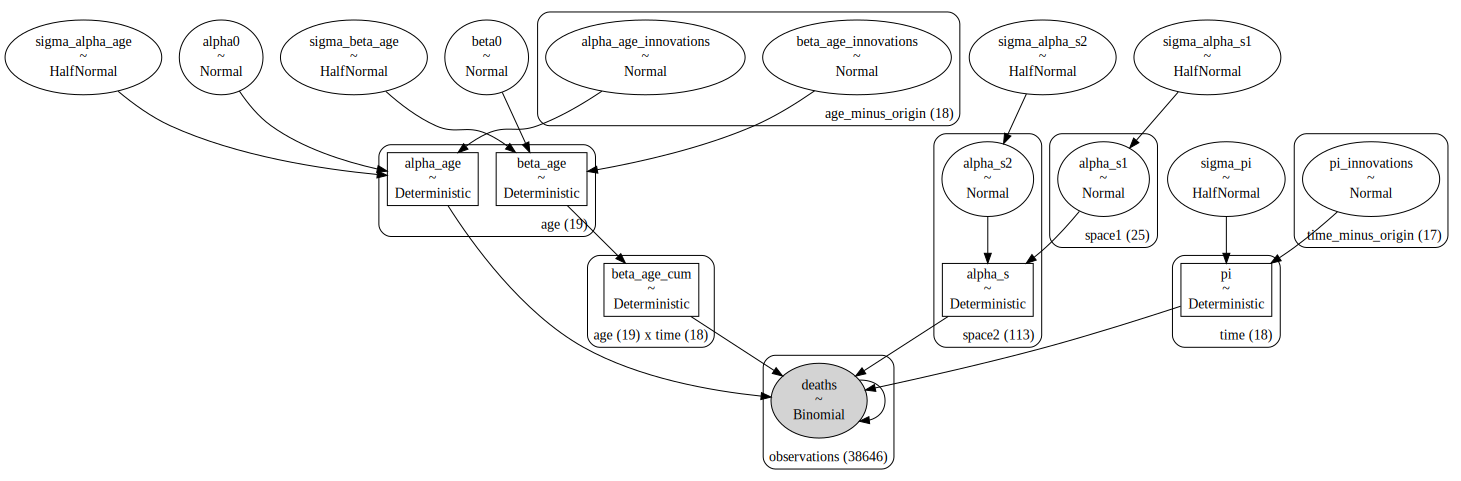

In [77]:
pm.model_to_graphviz(model)

In [78]:
with model:
    idata = pm.sample(1000, tune=1000)
    # idata = pm.sampling_jax.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha0, beta0, sigma_alpha_s1, sigma_alpha_s2, sigma_alpha_age, sigma_beta_age, sigma_pi, alpha_s1, alpha_s2, alpha_age_innovations, beta_age_innovations, pi_innovations]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2762 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/tar15/opt/anaconda3/envs/mortality-pymc/lib/python3.10/site-packages/arviz/stats/density_utils.py:491: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your da

array([[<AxesSubplot:title={'center':'alpha0'}>,
        <AxesSubplot:title={'center':'alpha0'}>],
       [<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'alpha_s1'}>,
        <AxesSubplot:title={'center':'alpha_s1'}>],
       [<AxesSubplot:title={'center':'alpha_s2'}>,
        <AxesSubplot:title={'center':'alpha_s2'}>],
       [<AxesSubplot:title={'center':'alpha_age_innovations'}>,
        <AxesSubplot:title={'center':'alpha_age_innovations'}>],
       [<AxesSubplot:title={'center':'beta_age_innovations'}>,
        <AxesSubplot:title={'center':'beta_age_innovations'}>],
       [<AxesSubplot:title={'center':'pi_innovations'}>,
        <AxesSubplot:title={'center':'pi_innovations'}>],
       [<AxesSubplot:title={'center':'sigma_alpha_s1'}>,
        <AxesSubplot:title={'center':'sigma_alpha_s1'}>],
       [<AxesSubplot:title={'center':'sigma_alpha_s2'}>,
        <AxesSubplot:title={'center':'sigma_alpha_s2'}>

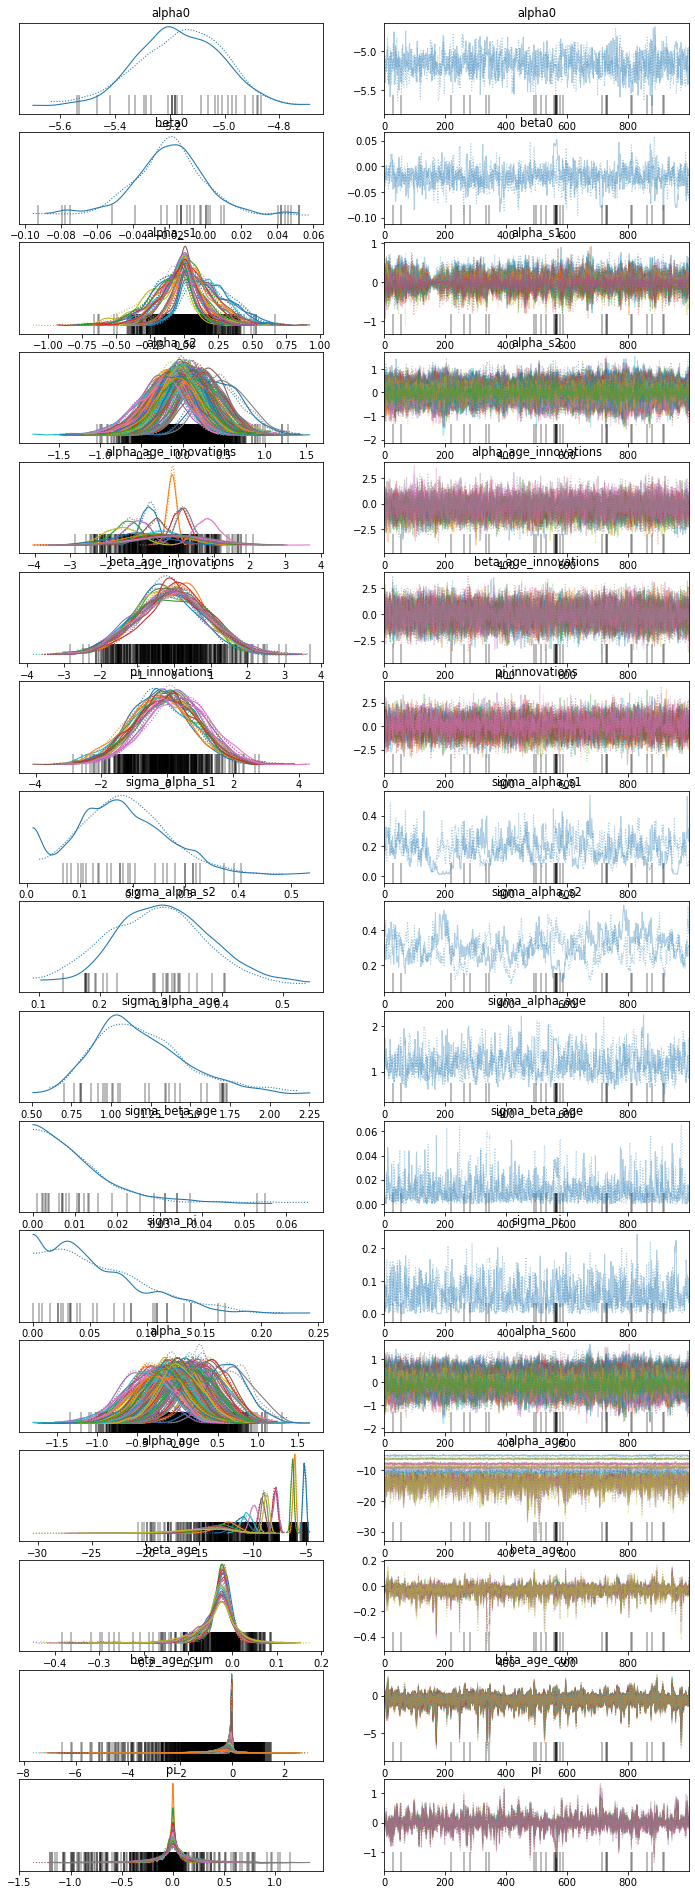

In [79]:
az.plot_trace(idata)